In [55]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [56]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [57]:
#Import data into tensorflow dataset object
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "training",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [58]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [59]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0])

tf.Tensor(
[[[116. 104. 108.]
  [121. 109. 113.]
  [109.  97. 101.]
  ...
  [157. 148. 153.]
  [152. 143. 148.]
  [147. 138. 143.]]

 [[116. 104. 108.]
  [118. 106. 110.]
  [114. 102. 106.]
  ...
  [155. 146. 151.]
  [150. 141. 146.]
  [145. 136. 141.]]

 [[123. 111. 115.]
  [123. 111. 115.]
  [128. 116. 120.]
  ...
  [151. 142. 147.]
  [146. 137. 142.]
  [142. 133. 138.]]

 ...

 [[110.  99. 105.]
  [118. 107. 113.]
  [127. 116. 122.]
  ...
  [131. 121. 129.]
  [131. 121. 129.]
  [129. 119. 127.]]

 [[102.  91.  97.]
  [105.  94. 100.]
  [112. 101. 107.]
  ...
  [132. 122. 130.]
  [132. 122. 130.]
  [130. 120. 128.]]

 [[129. 118. 124.]
  [117. 106. 112.]
  [110.  99. 105.]
  ...
  [139. 129. 137.]
  [139. 129. 137.]
  [137. 127. 135.]]], shape=(256, 256, 3), dtype=float32)


In [60]:
#every element that  you get is a tensor so, we need to convert that into numpy
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[2 1 0 1 0 1 1 0 2 1 0 1 1 1 0 1 0 0 2 1 0 1 1 0 2 0 1 1 0 0 0 0]


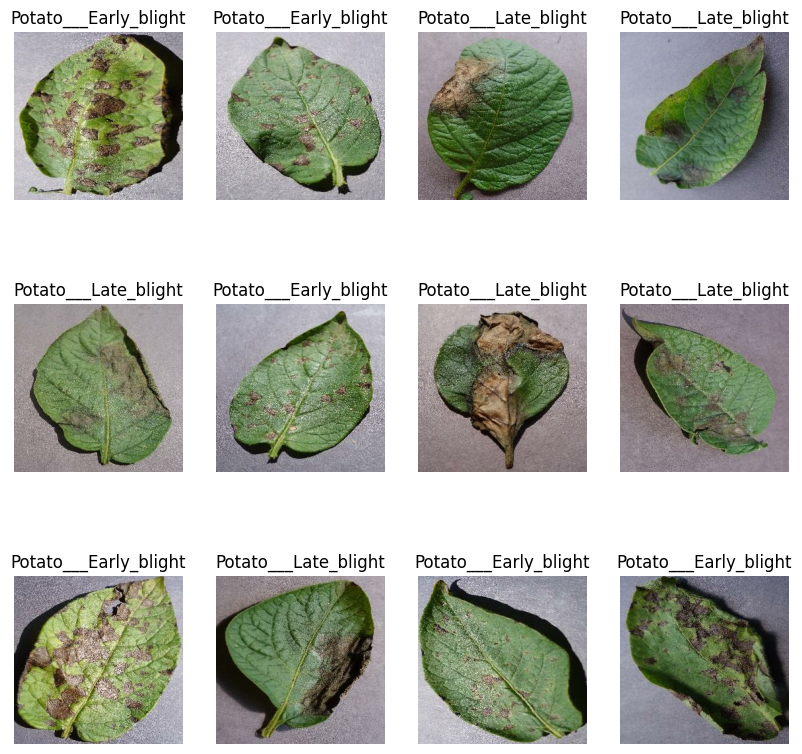

In [61]:
#visualize some image
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [62]:
len(dataset)

68

In [63]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [64]:
train_ds = dataset.take(54)
len(train_ds)

54

In [65]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [66]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [67]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [68]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [69]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [70]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [71]:
len(train_ds)

54

In [72]:
len(val_ds)

6

In [73]:
len(test_ds)

8

In [74]:
#Cache, Shuffle, and Prefetch the Dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [75]:
# Creating a Layer for Resizing and Normalization
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

In [76]:
#Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [77]:
#Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [78]:
#using a CNN coupled with a Softmax activation in the output layer and add the initial layers for resizing, normalization and Data Augmentation
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [79]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [80]:
#using adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [81]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.4839 - loss: 0.9550 - val_accuracy: 0.5365 - val_loss: 0.9071
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.6278 - loss: 0.7976 - val_accuracy: 0.6198 - val_loss: 0.8981
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.7965 - loss: 0.5109 - val_accuracy: 0.8698 - val_loss: 0.3736
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8698 - loss: 0.3339 - val_accuracy: 0.8906 - val_loss: 0.2731
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8910 - loss: 0.2767 - val_accuracy: 0.8698 - val_loss: 0.3006
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9046 - loss: 0.2194 - val_accuracy: 0.9010 - val_loss: 0.2012
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9354 - loss: 0.1696 - val_accuracy: 0.9219 - val_loss: 0.1645
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9301 - loss: 0.1838 - val_accuracy: 0.8906 - val_loss:

In [82]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 347ms/step - accuracy: 0.9918 - loss: 0.0224


In [84]:
scores
#Scores is just a list containing loss and accuracy value

[0.020893264561891556, 0.9921875]

In [85]:
#Plotting the Accuracy and Loss Curves
history

In [86]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [88]:
history.history.keys()
#loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [89]:
type(history.history['loss'])

list

In [90]:
len(history.history['loss'])

50

In [91]:
history.history['loss'][:5]
# show loss for first 5 epochs

[0.9270707368850708,
 0.7036707997322083,
 0.4592704176902771,
 0.3154785633087158,
 0.24163495004177094]

In [92]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

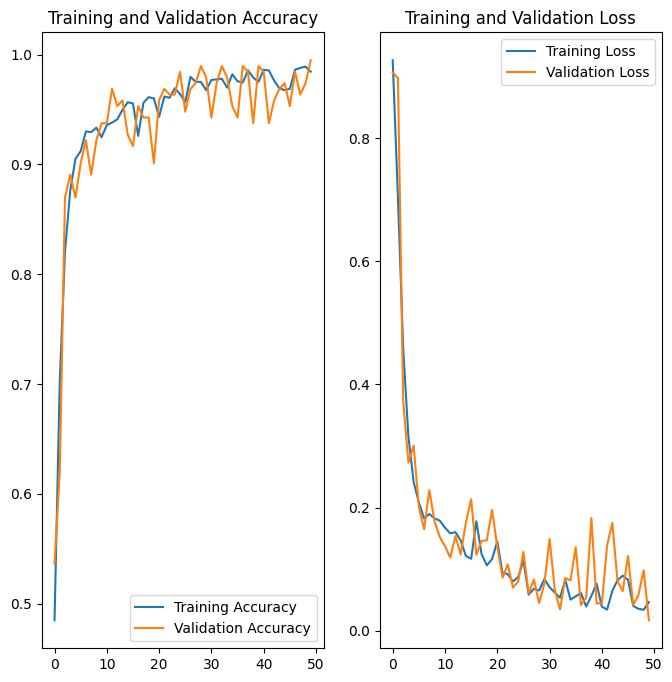

In [93]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
predicted label: Potato___Late_blight


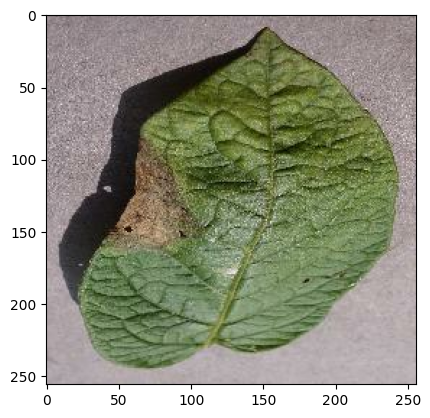

In [94]:
#Run prediction on a sample image
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [95]:
#function for inference
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


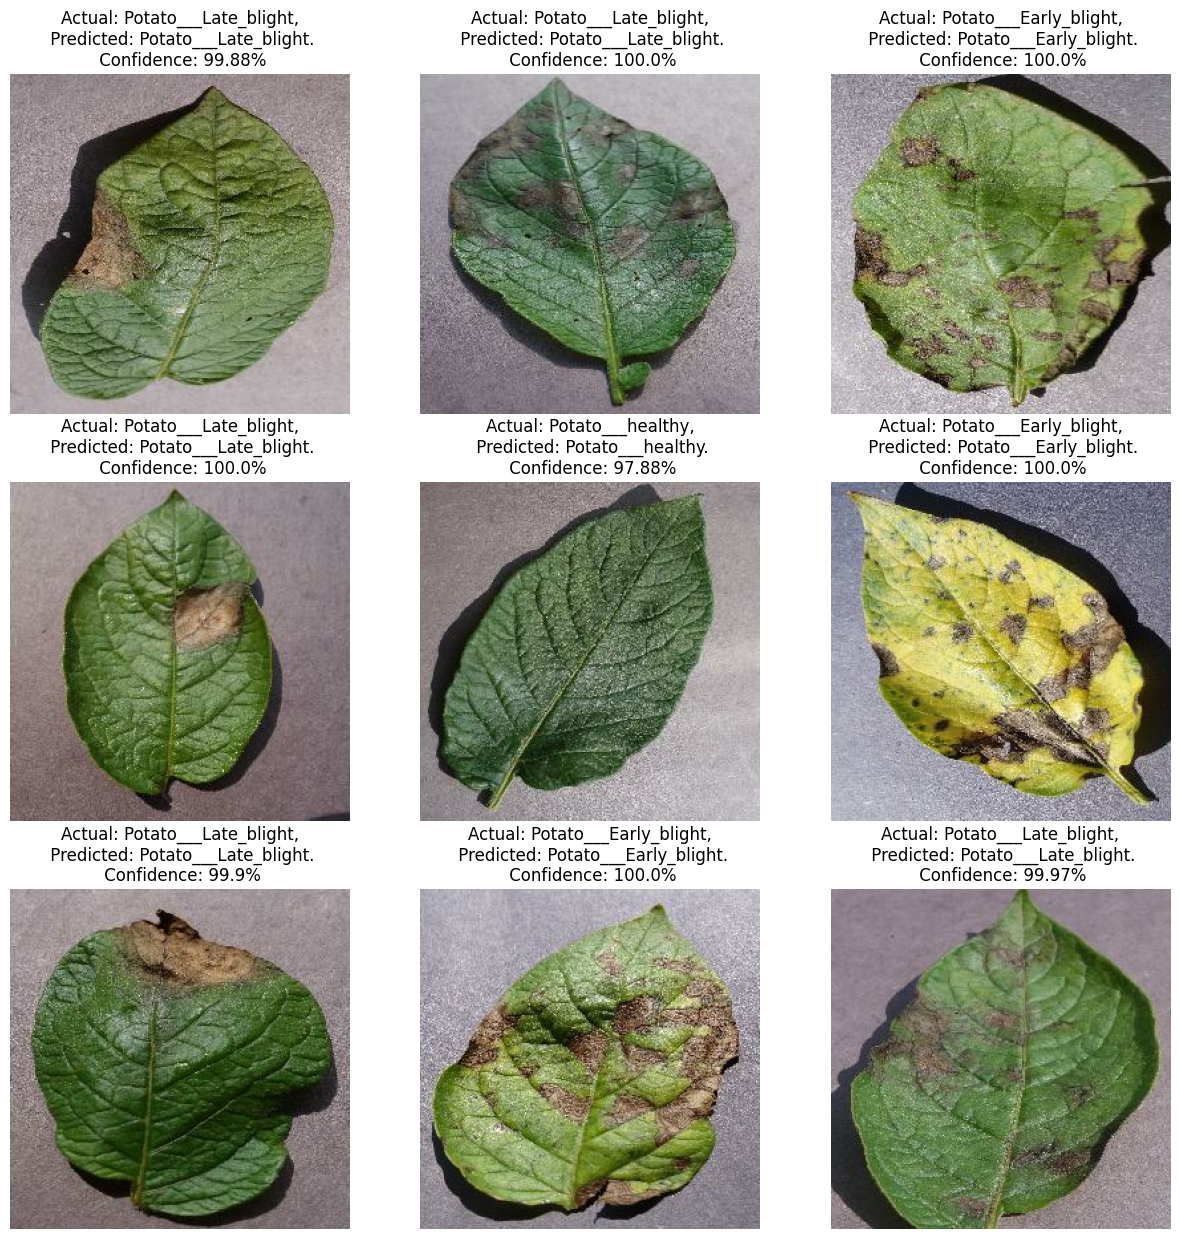

In [96]:
#running inference on few sample images
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")